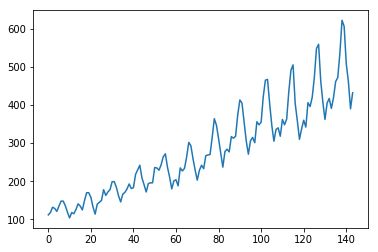

In [52]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [53]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [54]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [55]:
#We can also use the code from the previous section to load the dataset as a Pandas dataframe. 
#We can then extract the NumPy array from the dataframe and convert the integer values to floating point values,
#which are more suitable for modeling with a neural network.
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [56]:
#LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
#We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [57]:
#Splitting dataset into train and test
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [64]:
#The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, 
#and the look_back, which is the number of previous time steps to use as input variables to predict the next time period 
#— in this case defaulted to 1.

#This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).


#It can be configured, and we will by constructing a differently shaped dataset in the next section.
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [59]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [60]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0323
Epoch 2/100
 - 0s - loss: 0.0158
Epoch 3/100
 - 0s - loss: 0.0123
Epoch 4/100
 - 0s - loss: 0.0116
Epoch 5/100
 - 0s - loss: 0.0110
Epoch 6/100
 - 0s - loss: 0.0104
Epoch 7/100
 - 0s - loss: 0.0099
Epoch 8/100
 - 0s - loss: 0.0092
Epoch 9/100
 - 0s - loss: 0.0086
Epoch 10/100
 - 0s - loss: 0.0080
Epoch 11/100
 - 0s - loss: 0.0074
Epoch 12/100
 - 0s - loss: 0.0068
Epoch 13/100
 - 0s - loss: 0.0062
Epoch 14/100
 - 0s - loss: 0.0058
Epoch 15/100
 - 0s - loss: 0.0052
Epoch 16/100
 - 0s - loss: 0.0047
Epoch 17/100
 - 0s - loss: 0.0042
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0035
Epoch 20/100
 - 0s - loss: 0.0032
Epoch 21/100
 - 0s - loss: 0.0029
Epoch 22/100
 - 0s - loss: 0.0027
Epoch 23/100
 - 0s - loss: 0.0025
Epoch 24/100
 - 0s - loss: 0.0024
Epoch 25/100
 - 0s - loss: 0.0023
Epoch 26/100
 - 0s - loss: 0.0022
Epoch 27/100
 - 0s - loss: 0.0022
Epoch 28/100
 - 0s - loss: 0.0021
Epoch 29/100
 - 0s - loss: 0.0021
Epoch 30/100
 - 0s - lo

In [61]:
#Once the model is fit, we can estimate the performance of the model on the train and test datasets. 
#This will give us a point of comparison for new models.

#Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units
#as the original data (thousands of passengers per month).

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions(denormalizing values)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.23 RMSE
Test Score: 51.95 RMSE


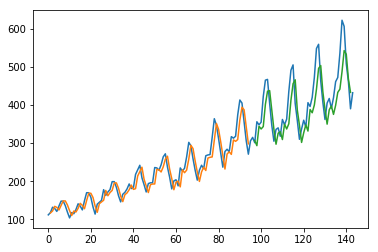

In [62]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
 - 2s - loss: 0.0543
Epoch 2/100
 - 0s - loss: 0.0259
Epoch 3/100
 - 0s - loss: 0.0167
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0129
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0094
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0074
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0060
Epoch 13/100
 - 0s - loss: 0.0056
Epoch 14/100
 - 0s - loss: 0.0052
Epoch 15/100
 - 0s - loss: 0.0050
Epoch 16/100
 - 0s - loss: 0.0049
Epoch 17/100
 - 0s - loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0043
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0042
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0041
Epoch 27/100
 - 0s - loss: 0.0040
Epoch 28/100
 - 0s - loss: 0.0040
Epoch 29/100
 - 0s - loss: 0.0039
Epoch 30/100
 - 0s - lo

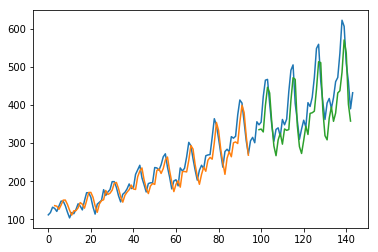

In [65]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()